In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape, concatenate, Lambda, MaxPool2D
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE
from keras.metrics import MeanAbsoluteError
from keras.losses import BinaryCrossentropy
import matplotlib.pyplot as mp
from tqdm import tqdm
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
# Data generation functions

def euclidean_d(l1, l2):
  return np.sqrt(np.sum(np.square(l1 - l2)))

def laplacian_graph(proj):
  # c = 0.05
  c = 0.1
  size = len(proj)
  g = np.zeros([size, size])
  for i in tqdm(range(size)):
    for j in range(size):
      dis = np.sqrt(np.sum(np.square(proj[i] - proj[j])))
      # print(dis)
      if dis > 0.5:
        g[i][j] = 0
      else:
        g[i][j] = np.exp(-((dis)**2/c))
  return g

def get_chosen_labeled_data(n, x, y):
  # for extremely small labeled dataset, we need to manuelly choose labeled examples

  preset_labeled_data_x = []
  preset_labeled_data_y = []
  preset_labeled_data_index = []
  for j in range(10):
    sum = 0
    counter = 0
    for i in range(len(y)):
      if y[i] == j:
        sum += proj[i]
        counter += 1

    av = sum/counter

    min_dis = 10000.0
    min_index = 10000.0
    for i in range(len(y)):
      new_dis = np.sqrt(np.sum(np.square(proj[i] - av)))
      if new_dis < min_dis:
        if y[i] == j:
          min_dis = new_dis
          min_index = i

    # plt.imshow(x[min_index])
    # print(av)
    # print(proj[min_index])
    # print(min_index)
    preset_labeled_data_x.append(x[min_index])
    preset_labeled_data_y.append(y[min_index])
    preset_labeled_data_index.append(min_index)
  
  times = int(n/10)+1
  # print(preset_labeled_data_y)
  preset_labeled_data_x_repeated = (preset_labeled_data_x*times)[:n]
  preset_labeled_data_y_repeated = (preset_labeled_data_y*times)[:n]

  return preset_labeled_data_x_repeated, preset_labeled_data_y_repeated, preset_labeled_data_x, preset_labeled_data_index

def get_labeled_data(n_l, n, x, y):
  labeled_data_x = x[:n_l].tolist()
  labeled_data_y = y[:n_l].tolist()

  times = int(n/n_l)+1
  labeled_data_x_repeated = (labeled_data_x*times)[:n]
  labeled_data_y_repeated = (labeled_data_y*times)[:n]
  labeled_data_index = np.linspace(0, n_l-1, n_l, dtype=int).tolist()

  return labeled_data_x_repeated, labeled_data_y_repeated, labeled_data_x, labeled_data_index
  
def get_fine_tuning_training_set2(n, x, g, preset_labeled_data_index):
  anchor_index = np.random.randint(0, len(g), n)
  another_index = np.random.randint(0, len(g), n)
  x_index = (preset_labeled_data_index*(int(n/(len(preset_labeled_data_index)))+1))[:n]
  anchor = []
  another = []
  similarity_anchor_another = []
  similarity_anchor_x = []
  similarity_another_x = []

  for i in range(n):
    anchor.append(x[anchor_index[i]])
    another.append(x[another_index[i]])
    similarity_anchor_another.append(g[anchor_index[i], another_index[i]])
    similarity_anchor_x.append(g[anchor_index[i], x_index[i]])
    similarity_another_x.append(g[x_index[i], another_index[i]])

  return anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x

def get_training_set_with_chosen_labeled_data(n, n_l, x, y, proj, g):
  if n_l < 20:
    x_train, y_train, preset_labeled_data_x, preset_labeled_data_index = get_chosen_labeled_data(n, x, y)
  else:
    x_train, y_train, preset_labeled_data_x, preset_labeled_data_index = get_labeled_data(n_l, n, x, y)
  anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x = get_fine_tuning_training_set2(n, x, g, preset_labeled_data_index)
  return x_train, y_train, anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x

# Testing

X_test = X_test[:1000]
X_test = np.reshape(X_test, [-1,28,28,1])

def get_acc(encoder, X_test):
  pred = encoder.predict(X_test)
  np.shape(pred)

  confusion_matrix = np.zeros([10,10])
  for i in range(1000):
    p = pred[i]
    index = np.argmax(p)
    confusion_matrix[Y_test[i]][index] += 1.0

  acc = 0
  for i in range(10):
    acc += confusion_matrix[i][i]

  return acc/1000

1


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
100%|██████████| 3000/3000 [01:33<00:00, 32.01it/s]


<function matplotlib.pyplot.show>

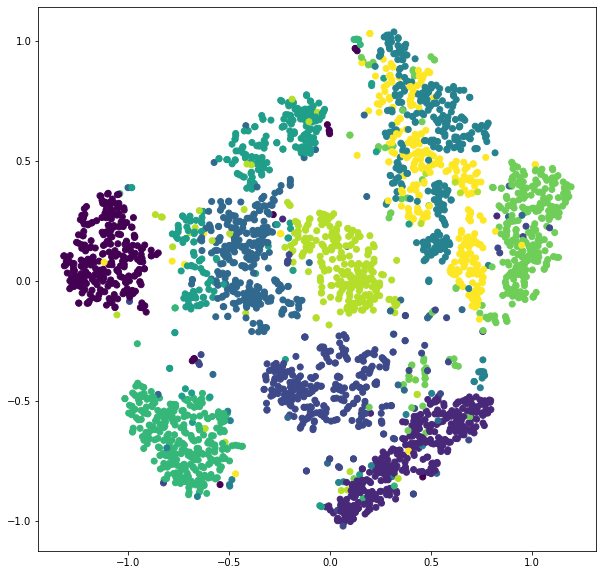

In [ ]:
x = X_train[:3000]
y = Y_train[:3000]
x_flatten = [np.reshape(e, (28*28)) for e in x]

# plt.imshow(x[3])
print(y[3])

model_TSNE = TSNE(n_components=2)
proj = model_TSNE.fit_transform(x_flatten)
proj = proj / 60.0

x1 = proj[:,0:1]
x2 = proj[:,1:2]

# plt.plot(x1,x2,'ro')

g = laplacian_graph(proj)
plt.figure(figsize=[10,10])
plt.scatter(x1,x2,c=y)
plt.show

In [ ]:
# generate dataset and check that we have labeled examples from all classes
n = 10000
n_l = 10
x_train, y_train, anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x = get_training_set_with_chosen_labeled_data(n, n_l, x, y, proj, g)
y_train[:n_l]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# get model

def unsupervised_loss(actual_similarity,pred_distance):
  h = 0.01
  my_loss2= actual_similarity * pred_distance
  return my_loss2 * h

def my_euclidean_distance(vectors):
	(featsA, featsB) = vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def get_second_model():
  input_x = Input((28,28,1))
  input_anchor = Input((28,28,1))
  input_another = Input((28,28,1))

  input_encoder = Input((28,28,1))
  conv = Conv2D(8,(3,3),activation='sigmoid')(input_encoder)
  conv = MaxPool2D(2,2)(conv)
  conv = Conv2D(16,(3,3),activation='sigmoid')(conv)
  conv = MaxPool2D(2,2)(conv)
  flatten = Flatten()(conv)
  flatten = Dense(20, activation='sigmoid')(flatten)
  output_encoder = Dense(10, activation='sigmoid')(flatten)
  encoder = Model(input_encoder, output_encoder)

  x_pred = encoder(input_x)
  anchor_pred = encoder(input_anchor)
  another_pred = encoder(input_another)
  similarity_anchor_another = Lambda(my_euclidean_distance)([anchor_pred, another_pred])
  similarity_anchor_x = Lambda(my_euclidean_distance)([anchor_pred, x_pred])
  similarity_another_x = Lambda(my_euclidean_distance)([x_pred, another_pred])

  model = Model([input_x, input_anchor, input_another], [x_pred, similarity_anchor_another, similarity_anchor_x, similarity_another_x])
  model.compile(optimizer="adam",loss=[tf.keras.losses.sparse_categorical_crossentropy, unsupervised_loss, unsupervised_loss, unsupervised_loss],
                # metrics=["accuracy"]
                )

  return model, encoder

# 注意：检查Similarity，大多数需要是0

In [ ]:
x_train = np.reshape(x_train, [-1,28,28,1])
anchor = np.reshape(anchor, [-1,28,28,1])
another = np.reshape(another, [-1,28,28,1])
y_train = np.array(y_train)
similarity_anchor_another = np.array(similarity_anchor_another)
similarity_anchor_x = np.array(similarity_anchor_x)
similarity_another_x = np.array(similarity_another_x)

model, encoder = get_second_model()

# history = model.fit([x_train, anchor, another], [y_train, similarity_anchor_another, similarity_anchor_x, similarity_another_x],
#                       epochs=50, batch_size=16,
#                       # validation_data=(X_0_and_1[n_labeled:n_labeled+500], Y_0_and_1[n_labeled:n_labeled+500]),
#                       )

results_acc = []
record_unsupervised_loss = []
record_supervised_loss = []
for i in range(101):
  print(f"step:{i}")
  # plt.figure(figsize=[8,8])
  # plt.subplot()
  # x = np.reshape(x, [-1,28,28,1])
  # y_pred = encoder.predict(x)
  # y_pred_max = [np.argmax(e) for e in y_pred]
  # plt.scatter(x1,x2,c=y_pred_max)
  # # plt.colorbar()
  # plt.show()
  history = model.fit([x_train, anchor, another], [y_train, similarity_anchor_another, similarity_anchor_x, similarity_another_x],
                      epochs=1, batch_size=16,
                      # validation_data=(X_0_and_1[n_labeled:n_labeled+500], Y_0_and_1[n_labeled:n_labeled+500]),
                      )
  
  # record_unsupervised_loss.append(history.history['lambda_3_loss'][0])
  # record_supervised_loss.append(history.history['model_2_loss'][0])
  acc = get_acc(encoder, X_test)
  print(acc)
  results_acc.append(acc)
  

step:0
Train on 10000 samples
10000/10000 [==============================] - 9s 876us/sample - loss: 1.2528 - model_loss: 1.2520 - lambda_loss: 2.0252e-04 - lambda_1_loss: 2.8932e-04 - lambda_2_loss: 2.9338e-04
0.493
step:1
Train on 10000 samples
  112/10000 [..............................] - ETA: 5s - loss: 0.3132 - model_loss: 0.3117 - lambda_loss: 2.3985e-04 - lambda_1_loss: 7.0798e-04 - lambda_2_loss: 4.9308e-04

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 5s 527us/sample - loss: 0.1507 - model_loss: 0.1490 - lambda_loss: 5.0424e-04 - lambda_1_loss: 6.0889e-04 - lambda_2_loss: 6.0864e-04
0.493
step:2
Train on 10000 samples
10000/10000 [==============================] - 5s 529us/sample - loss: 0.0500 - model_loss: 0.0481 - lambda_loss: 5.7740e-04 - lambda_1_loss: 6.7395e-04 - lambda_2_loss: 6.7604e-04


KeyboardInterrupt: ignored

In [ ]:
record_supervised_loss

[1.221888542175293,
 0.11535389721393585,
 0.03823903575539589,
 0.01897389441728592,
 0.011152433231472969,
 0.007165906485170126,
 0.00489004235714674,
 0.0034170409198850393,
 0.0024293907918035984,
 0.0017574894009158015,
 0.0012698597274720669,
 0.0009272033930756152,
 0.0006971198599785566,
 0.0005216634017415345,
 0.000407697691116482,
 0.0003377866232767701,
 0.00031777063850313425,
 0.0002971642534248531,
 0.00028356214170344174,
 0.0002469146274961531,
 0.00022653599444311112,
 0.00020498021331150085,
 0.00016847864026203752,
 0.00014213450776878744,
 0.00012091747339582071,
 0.00010459599434398115,
 8.714210707694292e-05,
 7.809973612893373e-05,
 6.744480924680829e-05,
 5.9972946473862976e-05,
 5.454776328406297e-05,
 5.087937097414397e-05,
 5.065111690782942e-05,
 4.613557757693343e-05,
 4.4035044993506745e-05,
 4.0071103285299614e-05,
 3.75670388166327e-05,
 3.4466542274458334e-05,
 3.366525561432354e-05,
 2.9666831323993392e-05,
 2.579096326371655e-05,
 2.4450835553579964

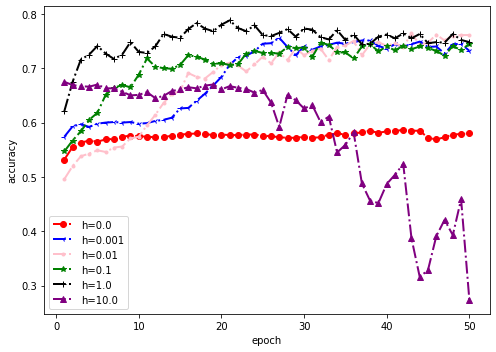

In [ ]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = "red"
plt.rcParams['lines.linestyle'] = "-"

epoch_axis = np.linspace(1,50,50)

# data01 = results_acc[:100]
# data02 = results_acc[:100]
data06 = results_acc[:100]
# data05 = results_acc[:100]

plt.figure(figsize=[7,5])
# plt.plot(epoch_axis,record_unsupervised_loss, c="red",linestyle='-.',marker='*')
# plt.plot(epoch_axis,np.log(record_supervised_loss), c="blue",linestyle='-.',marker='*')

plt.plot(epoch_axis,data01[:50], c="red",label="h=0.0",linestyle='-.',marker='o')
plt.plot(epoch_axis,data02[:50], c="blue",label="h=0.001",linestyle='-.',marker='3')
plt.plot(epoch_axis,data05[:50], c="pink",label="h=0.01",linestyle='-.',marker='.')
plt.plot(epoch_axis,data03[:50], c="green",label="h=0.1",linestyle='-.',marker='*')
plt.plot(epoch_axis,data04[:50], c="black",label="h=1.0",linestyle='-.',marker='+')
plt.plot(epoch_axis,data06[:50], c="purple",label="h=10.0",linestyle='-.',marker='^')
plt.xlabel("epoch")
plt.ylabel("accuracy")

# 小窗口 ： 位置
plt.legend(loc="lower left")

# 全显示 ：
plt.tight_layout()
plt.show()

In [ ]:
X_test = X_test[:1000]
X_test = np.reshape(X_test, [-1,28,28,1])

pred = encoder.predict(X_test)
np.shape(pred)

confusion_matrix = np.zeros([10,10])
for i in range(1000):
  p = pred[i]
  index = np.argmax(p)
  confusion_matrix[Y_test[i]][index] += 1.0

acc = 0
for i in range(10):
  acc += confusion_matrix[i][i]

print(f"acc: {acc/1000}")

confusion_matrix

# plt.imshow(confusion_matrix)

acc: 0.732


array([[ 82.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   2.],
       [  0., 122.,   0.,   0.,   0.,   0.,   1.,   0.,   3.,   0.],
       [  2.,  16.,  77.,   2.,   1.,   0.,   1.,   3.,  13.,   1.],
       [  1.,   3.,   1.,  81.,   1.,  10.,   3.,   3.,   3.,   1.],
       [  0.,   2.,   0.,   0.,  76.,   1.,   2.,   4.,   0.,  25.],
       [  4.,   1.,   0.,  20.,   1.,  52.,   2.,   3.,   1.,   3.],
       [  3.,   0.,   0.,   0.,   0.,   1.,  81.,   0.,   1.,   1.],
       [  0.,  11.,   0.,   0.,   6.,   0.,   0.,  74.,   0.,   8.],
       [  4.,   2.,   1.,   8.,   2.,   2.,   0.,   4.,  64.,   2.],
       [  0.,   1.,   0.,   1.,  56.,   1.,   0.,  11.,   1.,  23.]])

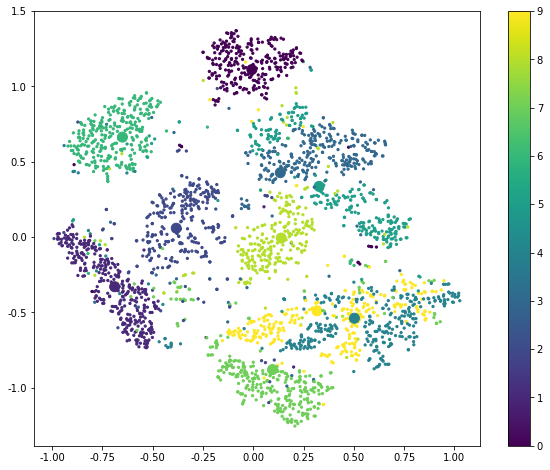

In [ ]:
labeled = [1709, 2159, 1395, 856, 2490, 1592, 147, 307, 348, 482]
s = np.ones(3000)*5
for e in labeled:
  s[e] = 100

plt.figure(figsize=[10,8])
plt.subplot()
plt.scatter(x1,x2,c=y,s=s)
plt.colorbar()
plt.show()

# plt.figure(figsize=[10,8])
# plt.subplot()
# x = np.reshape(x, [-1,28,28,1])
# y_pred = encoder.predict(x)
# y_pred_max = [np.argmax(e) for e in y_pred]
# plt.scatter(x1,x2,c=y_pred_max,s=np.ones(3000)*5)
# plt.colorbar()

# plt.show()

100%|██████████| 3000/3000 [01:47<00:00, 27.90it/s]


array([9.87250496e-08, 2.06214976e-06, 3.80255539e-08, ...,
       2.21929996e-07, 2.03519260e-07, 3.88824193e-07])

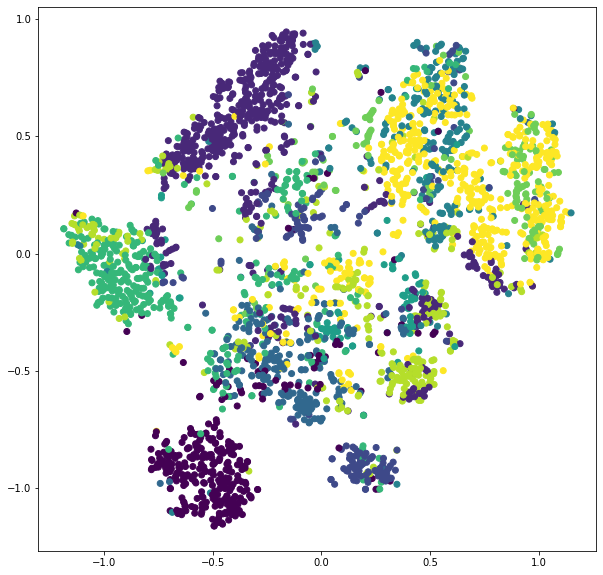

In [ ]:
x = np.reshape(x, [-1,28,28,1])
y_pred = encoder.predict(x)
y_pred_max = [np.argmax(e) for e in y_pred]

plt.figure(figsize=[10,10])
plt.scatter(x1,x2,c=y_pred_max)
plt.show

g = laplacian_graph(proj)
unstable = np.zeros(3000)
for i in tqdm(range(3000)):
  unstable[i] = np.average([g[i][j]*(np.sqrt(np.sum(np.square(y_pred[i] - y_pred[j])))) for j in range(3000)])

unstable

100%|██████████| 2500/2500 [00:11<00:00, 222.66it/s]


<function matplotlib.pyplot.show>

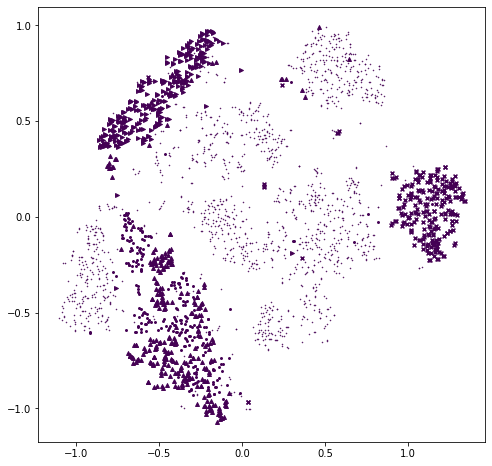

In [ ]:
plt.figure(figsize=[8,8])
siz = 15

for i in tqdm(range(len(y)-500)):
  if y[i] == 0:
    plt.scatter(x1[i],x2[i],c=y[i],marker='x',s=siz)
  elif y[i] == 1:
    plt.scatter(x1[i],x2[i],c=y[i],marker='>',s=siz)
  elif y[i] == 4:
    plt.scatter(x1[i],x2[i],c=y[i],marker='^',s=siz)
  elif y[i] == 9:
    plt.scatter(x1[i],x2[i],c=y[i],marker='.',s=siz)
  else:
    plt.scatter(x1[i],x2[i],c=y[i],marker='.',s=1)
plt.show